# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

Previously we've seen the power of Transfer Learning:
* Feature Extraction
* Fine-tuning
Now it's time to scale up all the classes in Food101 (101 total classes of food)

**GOAL:** To beat the original Food101 paper with 10% of the training data (leveraging the power of deep learning).

In [ ]:
# Checking if we're conected to a GPU:
!nvidia-smi

Sat Sep 30 05:31:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Creating Helper Functions:

In previous notebooks we've created a series of helper functions. Let's download them!

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-09-30 05:31:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-30 05:31:07 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook (The helper functions we want to use)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

Our goal is to bet the original Food101 paper with the training data. Let's download it!

**NOTE:** The data we're downloading comes from the original 101 dataset but has been processed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
# Downloading and unzipping data:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

#Using unzip Helper Function:
unzip_data("101_food_classes_10_percent.zip")

# Setting up train and test directories:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-09-30 05:31:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.31.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.31.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  34.3MB/s    in 50s     

2023-09-30 05:32:01 (30.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# Checking the number of image/classes there are: (there should be 101)
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fish_and_chips'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '10

In [ ]:
# Setup data inputs:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = 'categorical',
                                                                                image_size = IMG_SIZE,
                                                                                )
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               label_mode = 'categorical',
                                                                               image_size = IMG_SIZE,
                                                                               shuffle = False) # Don't shuffle test data for prediction analysis. We want it to keep the order it is right now so whem we evaluate it later is useful.



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


from keras.engine.training import Model
from backcall.backcall import callback_prototype
## Train a "big dog" model with transfer learning on 10% of 101 food classes:

Steps:
1. Create a ModelCheckpoint callback_prototype
2. Create a data augmentation layer to build data augmentation right into the model
3. Build a headless (no top layers) Functional EfficientNet backboned-model (we'll create our own output layer)
4. Compile our Model
5. Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the train data to save epoch time)
                                                                             

In [ ]:
##################################
### Create checkpoint callback ###
##################################

checkpoint_path = '101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         monitor = 'val_accuracy',
                                                         save_best_only = True)

In [ ]:
#########################
### Data Augmentation ###
#########################

# Create data augmentation layer to incorporate it right into the model:
from tensorflow.keras import layers
# from tensorflow.keras import preprocessing ### Not needed to import for this version of Tensorflow. We call the data augmentation parameters with "layers." instead of "preprocessing"
from tensorflow.keras.models import Sequential

# Setup data augmentation:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
    # preprocessing.Rescaling(1/255.) # REMEBER: This is not needed in this model, because EfficientNets in TensorFlow have Rescaling built-in !!! BUT REQUIRED for models like: ResNet50 !!!
], name = 'data_augmentation')


* Link to EfficientNetB0 model's documentation (paper): https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [ ]:
###########################
### Creating Base Model ###
###########################

# Create the BASE MODEL and FREEZE its layers (to extract features):
base_model = tf.keras.applications.EfficientNetV2B0(include_top = False) # We're changing the top layers because our problem (DS) has a different input layer number... in this case 101 classes
base_model.trainable = False

# Setup model architecture with trainable top layers:
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(inputs) # Augments images (only happens during the training phase)
x = base_model(x, training = False) # Once done data augmentation, we pass it to our base model. ### Putting the base model in inference mode so weights which need to stay frozen, stay frozen!
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x) # Unlike the 2 lines of code above (which are models), in this one we pass x outside, since it's a layer!
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = 'softmax', name = 'output_layer')(x) # REMEMBER: 'softmax' because it's classification

model = tf.keras.Model(inputs, outputs)

24274472/24274472 [==============================] - 1s 0us/step


In [ ]:
# Get Sumary of model created:
model.summary() # only so few parameters (129,381) are trainable, because only the one in the output layer are!

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Compile model
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
# Fit model. Train it for 5 epochs on the train dataset AND validate on 15%
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5, # Fitting it for 5 epochs to keep experiments quick !!!
                                           steps_per_epoch = len(train_data_all_10_percent),
                                           validation_data = test_data_all_10_percent,
                                           validation_steps = int(0.15 * len(test_data_all_10_percent)), # Only testing on 15% of data because this dataset is too large...
                                           callbacks = [checkpoint_callback]
                                           )

Epoch 1/5
237/237 [==============================] - 138s 516ms/step - loss: 3.5260 - accuracy: 0.2404 - val_loss: 2.6392 - val_accuracy: 0.4338
Epoch 2/5
237/237 [==============================] - 86s 363ms/step - loss: 2.4204 - accuracy: 0.4455 - val_loss: 2.1642 - val_accuracy: 0.4939
Epoch 3/5
237/237 [==============================] - 70s 294ms/step - loss: 2.0467 - accuracy: 0.5130 - val_loss: 1.9747 - val_accuracy: 0.5193
Epoch 4/5
237/237 [==============================] - 61s 258ms/step - loss: 1.8362 - accuracy: 0.5559 - val_loss: 1.8437 - val_accuracy: 0.5408
Epoch 5/5
237/237 [==============================] - 58s 245ms/step - loss: 1.6842 - accuracy: 0.5830 - val_loss: 1.7784 - val_accuracy: 0.5437


In [ ]:
fine_tuning_results = model.evaluate(test_data_all_10_percent)

790/790 [==============================] - 39s 49ms/step - loss: 1.6310 - accuracy: 0.5690


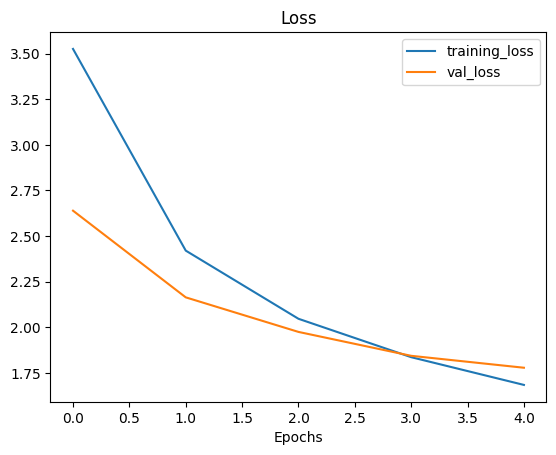

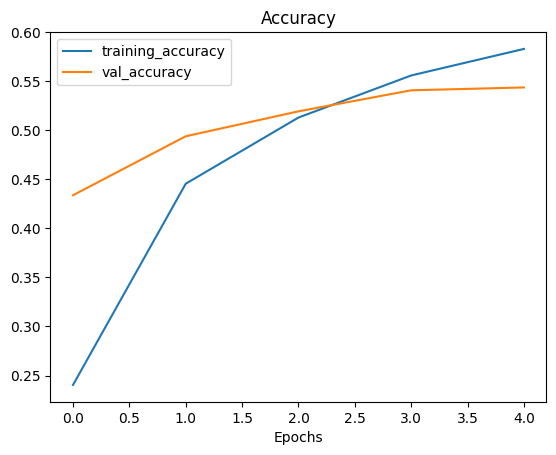

In [ ]:
# Plotting loss curves:
plot_loss_curves(history_all_classes_10_percent)

**NOTE:** As observed in the loss curves above, it's overfitting !!! It's learning th epatterns too well. Performing too well on the training data, but not generalizing on unseen data.

* To try to improve its performance, let's do some fine-tunning next:

## Fine-tuning

* By un-freezing some layers

**NOTE:** This time we're only infreezing the last 5, and they're the last ones, because in neural nets, the layers at the beginning learn larger patters, and what we are trying to do now is to help the model lear those little patters better, so it is able to easily identify them.

In [ ]:
# UNFREEZE all layers in the base model:
base_model.trainable = True

# NOTE: Since this model is doing pretty well, we should not unfreeze as many layers
# RE-FREEZE every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate (best practice: lower lr when fine-tuning by 10x smaller )
model.compile(loss = tf.keras.losses.categorical_crossentropy,
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Learning rate lowered by 10x
              metrics = ['accuracy'])

In [ ]:
# Checking which layers in the model are trainable:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avg_pool_layer True
output_layer True


In [ ]:
# Checking which layers in the base model are trainable:
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [ ]:
# Fine-tune model with 5 layers unforzen for 5 extra epochs (10) starting from the epoch we left off at (using callbacks)

fine_tune_epochs = 10 # epoch = 10 is the total num of epochs, because the model has already been fitted for 5 epochs (feature extraction)

# Fine-tune the model:
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data_all_10_percent,
                                                     validation_steps = int(0.15 * len(test_data_all_10_percent)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])  # -1 because we're starting at the last epoch


Epoch 5/10
237/237 [==============================] - 61s 221ms/step - loss: 1.4867 - accuracy: 0.6242 - val_loss: 1.7274 - val_accuracy: 0.5413
Epoch 6/10
237/237 [==============================] - 47s 200ms/step - loss: 1.3915 - accuracy: 0.6405 - val_loss: 1.7005 - val_accuracy: 0.5508
Epoch 7/10
237/237 [==============================] - 42s 176ms/step - loss: 1.3241 - accuracy: 0.6561 - val_loss: 1.6926 - val_accuracy: 0.5477
Epoch 8/10
237/237 [==============================] - 40s 167ms/step - loss: 1.2768 - accuracy: 0.6615 - val_loss: 1.6864 - val_accuracy: 0.5482
Epoch 9/10
237/237 [==============================] - 37s 157ms/step - loss: 1.2478 - accuracy: 0.6717 - val_loss: 1.6655 - val_accuracy: 0.5588
Epoch 10/10
237/237 [==============================] - 37s 154ms/step - loss: 1.2064 - accuracy: 0.6873 - val_loss: 1.6550 - val_accuracy: 0.5604


In [ ]:
# Evaluate on the whole test dataset:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 38s 48ms/step - loss: 1.4811 - accuracy: 0.6021


[1.4811396598815918, 0.6020990014076233]

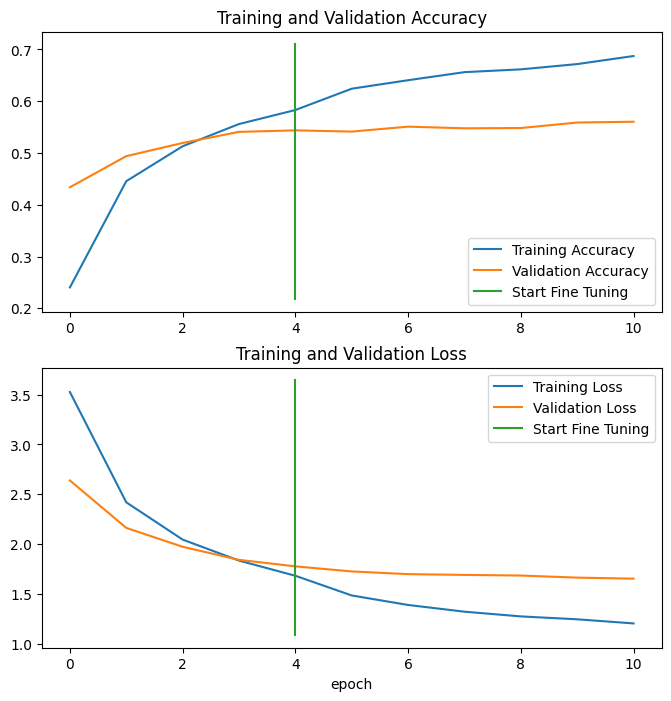

In [ ]:
# Compare the histories of feature extraction model (1st) VS fine tuned model (2nd)
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and loading the model:
To use the model in an external application, we need to save it and export it somewhere

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


In [ ]:
!ls /content/drive/MyDrive/TensorFlow/TensorFlow_Course/


 00_tensorflow_fundamentals.ipynb
 01_neural_network_regression_with_tensorflow_video.ipynb
 02_neural_network_classification_with_TensorFlow_Roger.ipynb
 04-transfer-learning-in-tensorflow-part1-feature-extraction-Roger.ipynb
 101_classes_10_percent_data_model_checkpoint.data-00000-of-00001
 101_classes_10_percent_data_model_checkpoint.index
 101_food_classes_10_percent
 101_food_classes_10_percent_saved_big_dog_model
 101_food_classes_10_percent_saved_big_dog_model.h5
 101_food_classes_10_percent.zip
'1-Dq5TZ8ChxmDtsu_y9F9sbZiAr8lNDiQ?usp=sharing'
'1-Dq5TZ8ChxmDtsu_y9F9sbZiAr8lNDiQ?usp=sharing.1'
 assets
 best_model_HDF5_format.h5
 checkpoint
 drive
 fingerprint.pb
 helper_functions.py
 helper_functions.py.1
 __MACOSX
 model
 saved_model.pb
 TensorFlow.gdoc
 variables


In [ ]:
# import os
# os.chdir('/content/drive/MyDrive/TensorFlow/TensorFlow_Course/')


In [ ]:
# import tensorflow as tf
# tf.keras.backend.clear_session()


In [ ]:
# https://drive.google.com/drive/folders/1kY26wC8ZCFnJx3vGvXLcC_6QdWUHIDiu?usp=drive_link
# model.save("drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model")


### Saving Model

In [ ]:
### Saving model with Keras file ###
# model = tf.keras.models.load_model(drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model)
model.save('drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model', include_optimizer=False)


In [ ]:
# Loading Model USING KERAS:
# model = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model".split(".")[0])

# Loading Model NOT USING KERAS:
# model = tf.saved_model.load_model("drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model".split(".")[0])


# loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
import tensorflow as tf

# Download pre-trained model from Google Storage:
!wget https://drive.google.com/drive/folders/1-47a9bik9FzZDgo_Y5c2acLZXbUmMYRo?usp=sharing

loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TensorFlow/TensorFlow_Course/101_food_classes_10_percent_saved_big_dog_model".split(".")[0])

--2023-09-30 05:45:27--  https://drive.google.com/drive/folders/1-47a9bik9FzZDgo_Y5c2acLZXbUmMYRo?usp=sharing
Resolving drive.google.com (drive.google.com)... 108.177.126.102, 108.177.126.100, 108.177.126.139, ...
Connecting to drive.google.com (drive.google.com)|108.177.126.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘1-47a9bik9FzZDgo_Y5c2acLZXbUmMYRo?usp=sharing’

1-47a9bik9FzZDgo_Y5     [ <=>                ] 277.33K  1.70MB/s    in 0.2s    

2023-09-30 05:45:28 (1.70 MB/s) - ‘1-47a9bik9FzZDgo_Y5c2acLZXbUmMYRo?usp=sharing’ saved [283984]



In [ ]:
# # Check to see if loaded model is a trained model
# loaded_loss, loaded_accuracy = model.evaluate(test_data)
# loaded_loss, loaded_accuracy

In [ ]:
# Compiling and fitting loaded_model:
loaded_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                     optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # Learning rate lowered by 10x
                     metrics = ['accuracy'])

In [ ]:
history_loaded_model = loaded_model.fit(train_data_all_10_percent,
                                        epochs = fine_tune_epochs,
                                        validation_data = test_data_all_10_percent,
                                        validation_steps = int(0.15 * len(test_data_all_10_percent)),
                                        initial_epoch = history_all_classes_10_percent.epoch[-1])  # -1 because we're starting at the last epoch

Epoch 5/10
237/237 [==============================] - 46s 158ms/step - loss: 1.1825 - accuracy: 0.6826 - val_loss: 1.6593 - val_accuracy: 0.5596
Epoch 6/10
237/237 [==============================] - 35s 147ms/step - loss: 1.1392 - accuracy: 0.6981 - val_loss: 1.6493 - val_accuracy: 0.5638
Epoch 7/10
237/237 [==============================] - 32s 135ms/step - loss: 1.1247 - accuracy: 0.7023 - val_loss: 1.6644 - val_accuracy: 0.5638
Epoch 8/10
237/237 [==============================] - 33s 138ms/step - loss: 1.0974 - accuracy: 0.7048 - val_loss: 1.6328 - val_accuracy: 0.5702
Epoch 9/10
237/237 [==============================] - 35s 147ms/step - loss: 1.0721 - accuracy: 0.7147 - val_loss: 1.6550 - val_accuracy: 0.5636
Epoch 10/10
237/237 [==============================] - 31s 128ms/step - loss: 1.0322 - accuracy: 0.7257 - val_loss: 1.6542 - val_accuracy: 0.5649


In [ ]:
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data_all_10_percent)
loaded_loss, loaded_accuracy

790/790 [==============================] - 39s 49ms/step - loss: 1.4569 - accuracy: 0.6107


(1.4569271802902222, 0.6107326745986938)

In [ ]:
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results


790/790 [==============================] - 39s 49ms/step - loss: 1.4569 - accuracy: 0.6107


[1.4569271802902222, 0.6107326745986938]

In [ ]:
# The results from our loaded model (above) should be very similar to the results below (original ones)
all_classes_10_percent_fine_tune_results

[1.4811396598815918, 0.6020990014076233]

## Evaluating teh performance of our bid dog model across all different classes

Let's make some predictions, visualize them and then find out which predictions were the "most" wrong.


In [ ]:
# Downloading pretrained model (The one that was prepared earlier, so all predictions are similar)
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-09-30 05:50:30--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.207, 108.177.119.207, 108.177.126.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  25.2MB/s    in 1.8s    

2023-09-30 05:50:32 (25.2 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")


In [ ]:
# Evaluate loaded model (The one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data_all_10_percent)
results_downloaded_model

790/790 [==============================] - 54s 66ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making preditcions with our trained model

In [ ]:
# Make predictions with our model:
preds_probs = model.predict(test_data_all_10_percent, verbose = 1) # Set verbosity to see how long is left
preds_probs

790/790 [==============================] - 49s 60ms/step


array([[5.95422499e-02, 3.57421641e-06, 4.13771868e-02, ...,
        1.41387257e-09, 8.35307801e-05, 3.08975508e-03],
       [9.64016914e-01, 1.37533007e-09, 8.47806223e-04, ...,
        5.42869529e-05, 7.83620738e-12, 9.84662241e-10],
       [9.59258676e-01, 3.25337387e-05, 1.48669758e-03, ...,
        7.18913384e-07, 5.43975261e-07, 4.02759979e-05],
       ...,
       [1.51387385e-05, 4.09730448e-04, 8.02507671e-10, ...,
        2.17429133e-05, 1.07972855e-05, 5.37898600e-01],
       [5.93180908e-03, 4.92368173e-03, 9.98231582e-03, ...,
        1.19894401e-04, 1.68902789e-05, 4.52181771e-02],
       [3.13635431e-02, 7.50526227e-03, 4.29750828e-04, ...,
        5.03463787e-04, 5.20564117e-06, 6.90627694e-01]], dtype=float32)

In [ ]:
len(test_data_all_10_percent)

790

In [ ]:
790*32

25280

In [ ]:
# How many predictions are there?
len(preds_probs) # We get 25250, because there is one prediction for every test image!

25250

In [ ]:
# What's the shape of our predictions
preds_probs.shape # Results = 25250 is the amount of images as seen before, AND 101 are the food classes

(25250, 101)

In [ ]:
# Checking what the first 10 predictions look like:
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
# What does the 1st prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0]) # Generally all tensors sum to 1

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

**NOTE:** Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.  

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities):
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}") # Result: 52 ### This means that for sample 0, highest predicted class is 52

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-

In [ ]:
test_data_all_10_percent.class_names[52]

'gyoza'

In [ ]:
# Getting the predicted classes of each label:
pred_classes = preds_probs.argmax(axis = 1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes do we have?
len(pred_classes)

25250

**NOTE:** Now we've got a predictions array of all of our predictions, we need to compare them to the actual labels to see how they match up (copmare them with the original dataset)

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currentlty test labels look like this: [0, 0, 0, 1, ... 0, 0]. We want the index value where the "1" occurs

y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluate our models' predictions:

One way to check that our model's predictionsarray is in the same order as our test labels array is to find our accuracy score.

In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

# Calling the accuracy score: ### IT'S CORRECT, SINCE IT'S very close to the NUMBER AS THE ACCURACY SCORE WE GOT FROM "results_downloaded_model" IN THE CELL ABOVE!!!
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this number come close to our model's evaluate results?
import numpy as np

np.isclose(results_downloaded_model[1], sklearn_accuracy) ### We get true, which means it's close enough!

True

## Let's get visual: Making a Confusion Matrix

In [ ]:
# Calling our confusion matric function from the already loaded helper_functions:
# from helper_functions import make_confusion_matrix

In [ ]:
# Get a list of class names:
class_names = test_data_all_10_percent.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
len(class_names)

101

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Making some changes to our Confusion Matrix function for our x-labels to print vertically, since now they are unreadable:

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### CHANGED (plot x-labels vertically) ###

  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes = class_names,
                      figsize = (100, 100),
                      text_size = 20,
                      savefig = True)

## Keeping the evaluation train gaoing. Now it's time for a classification resport

Scikit-learn has a helpful function for acquiring many different classification metrics per class (i.e. precision, recall and F1) called classification_report. Let's try it out!


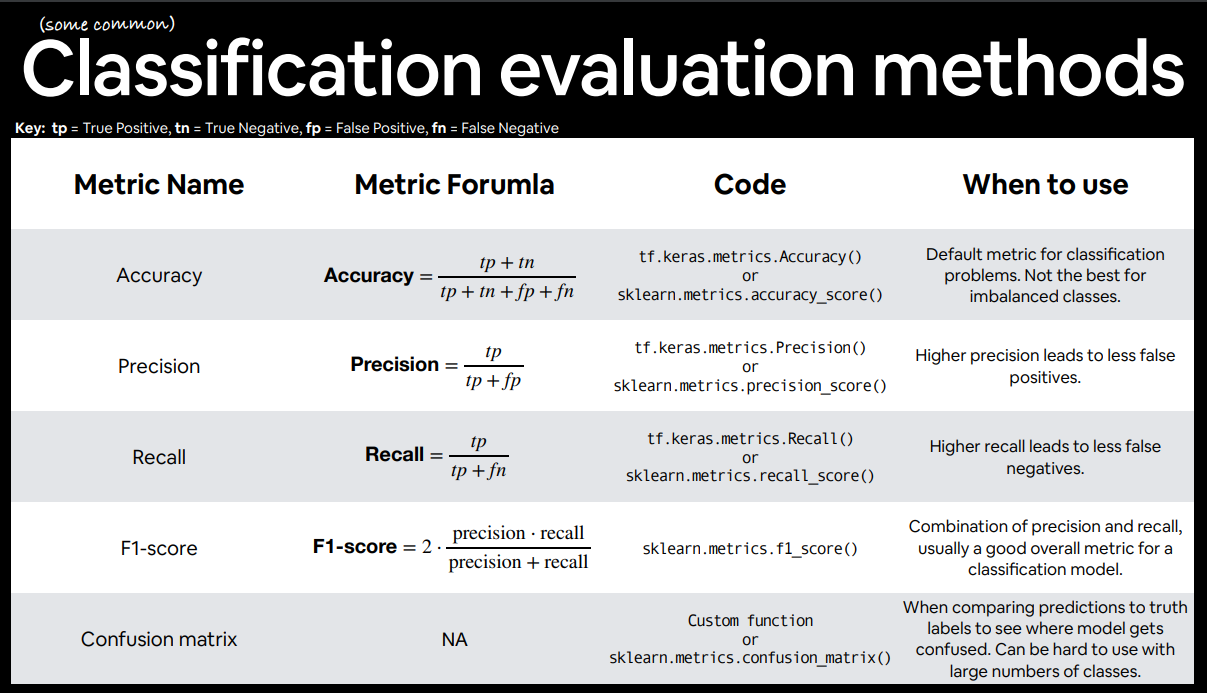

In [ ]:
# Creating a Calssification Report to analyze the confusion metrix results:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

The numbers above give us a great class-by-class evaluation of our model's predictions, but with so many classes that makes it very hard to understand.
How about we create a visualization to get a better understanding?

In [ ]:
# Getting a dictionary of the classification report
classification_report_dict = classification_report(y_true = y_labels,
                                                   y_pred = pred_classes,
                                                   output_dict = True)
classification_report_dict

In [ ]:
# This way we can find the class names: class_names[N] where N is the index of a class
class_names[70]

In [ ]:
classification_report_dict["99"]["f1-score"]

In [ ]:
# Let's plot an empty dictionary:
class_f1_scores = {}

# Looping through classification report dictionary items:
for k, v in classification_report_dict.items():
  if k == "accuracy": # When it gets to accuracy key, we want to stop
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"] # We want it to be an integer!
class_f1_scores

In [ ]:
# Turning f-1 scores into dataframes for visualization
import pandas as pd

# class_f1_scores
f1_scores = pd.DataFrame({'class_name': list(class_f1_scores.keys()),
                        'f1-score': list(class_f1_scores.values())})

f1_scores.head()

In [ ]:
# # Plotting the f1-score dataframes with a bar chart:

# import matplotlib.pyplot as plt

df = pd.DataFrame(f1_scores)
df.sort_values(by = 'f1-score', ascending = False)

# fig, ax = plt.subplots(figsize = (12, 25))
# scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # Get f1-scores values
# # scores = ax.barh(range(len(f1_scores)), df['f1-score'].values) # Use the sorted DataFrame 'df'


# ax.set_yticks(range(len(f1_scores)))
# ax.set_yticklabels(list(f1_scores['class_name']))
# ax.set_xlabel('f1-score')
# ax.set_title('F1-scores for 101 Different Food classes (Predicted by Food Vision mini)')
# ax.invert_yaxis(); # With this the order gets reversed

# # Creating a function for

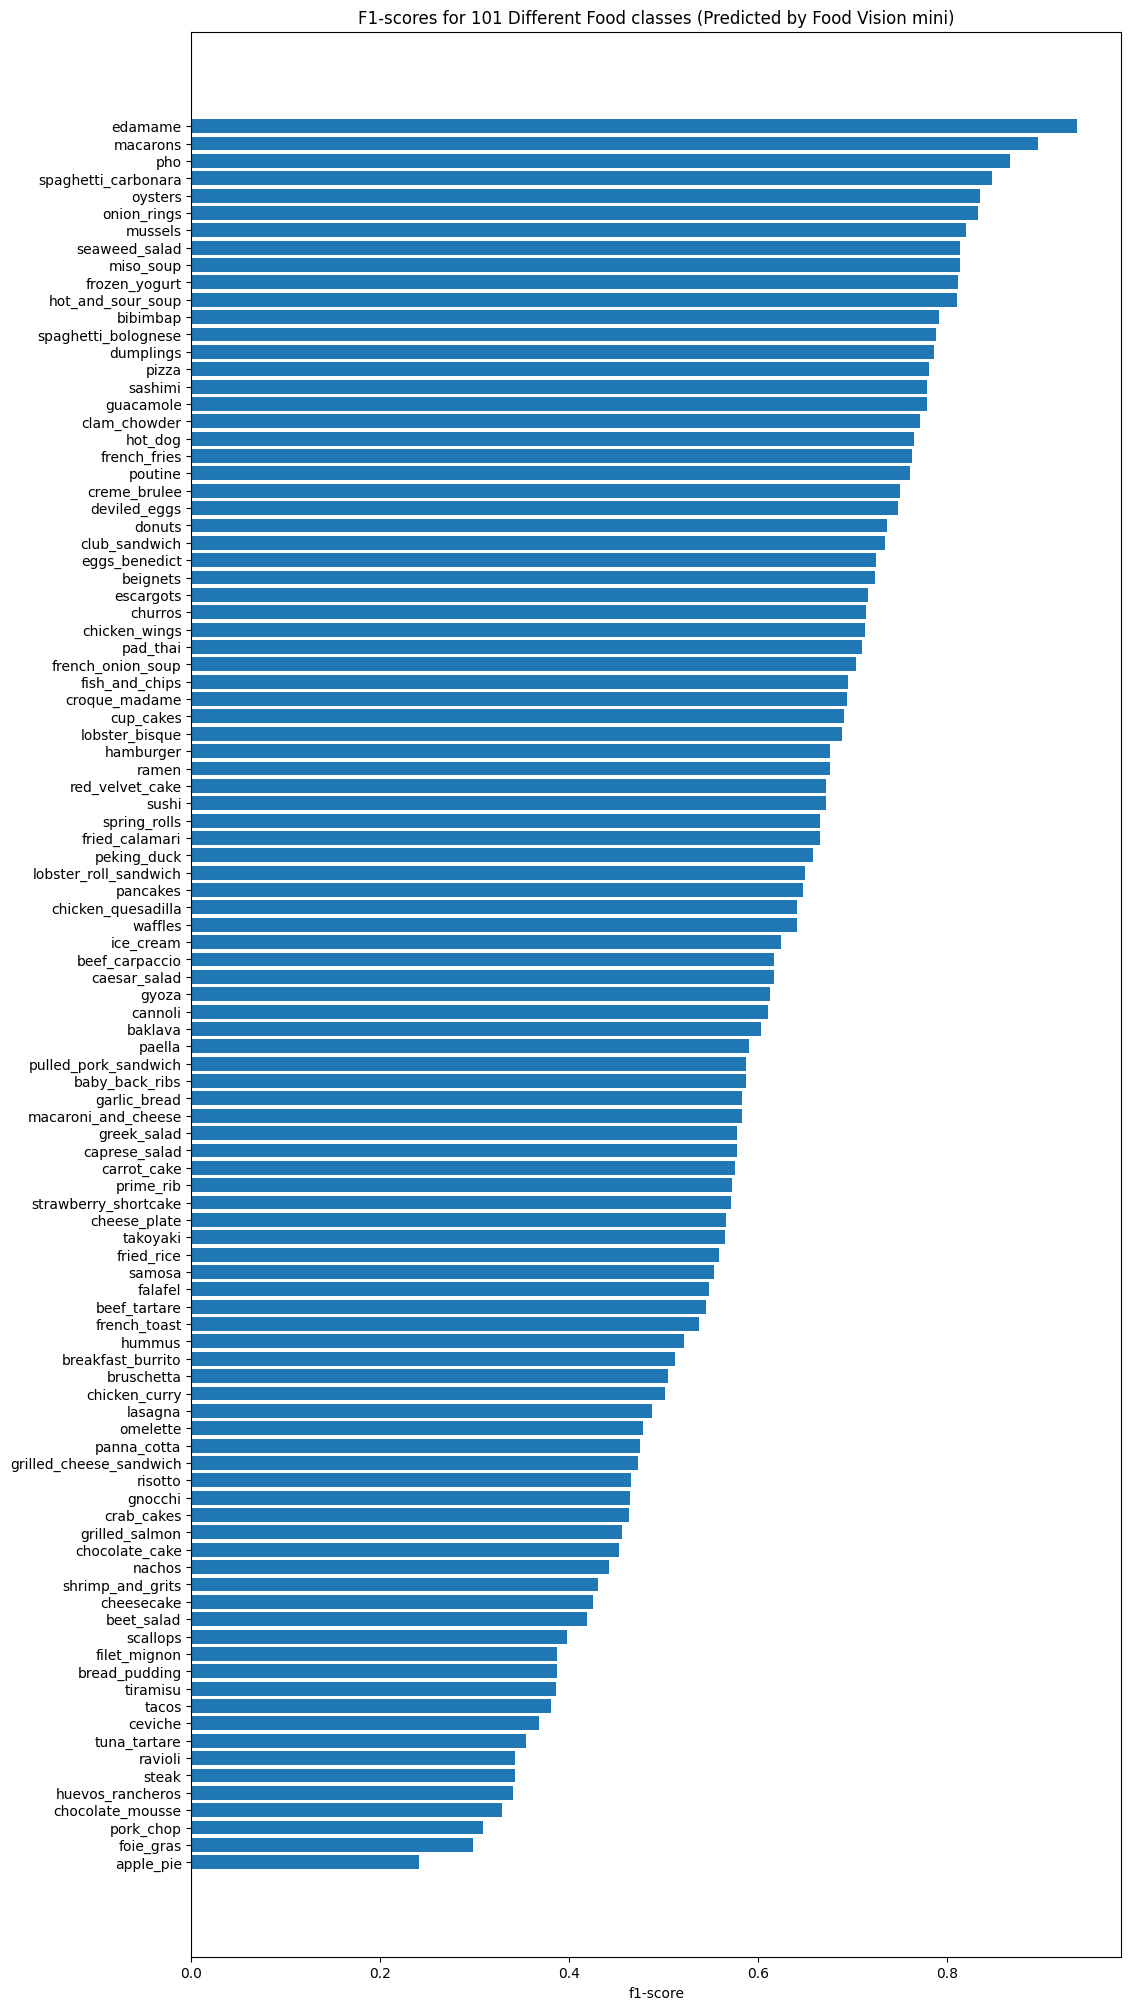

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have f1_scores DataFrame

# Sort the DataFrame by 'f1-score' column in descending order
df_sorted = df.sort_values(by='f1-score', ascending=False)

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(df_sorted)), df_sorted['f1-score'].values)  # Use the sorted DataFrame 'df_sorted'

ax.set_yticks(range(len(df_sorted)))
ax.set_yticklabels(list(df_sorted['class_name']))
ax.set_xlabel('f1-score')
ax.set_title('F1-scores for 101 Different Food classes (Predicted by Food Vision mini)')
ax.invert_yaxis()

plt.show()


In [ ]:
# NOW ADD VALUES TO THE END OF EACH BAR OF WHAT THE ACTUAL f1-score IS (HINT: USE THE "autolabel" FUNCTION FROM: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [ ]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

**EXERCISE:** Visualizing some of the most poorly predicted classes (i.e. apple pie, pork chop...)

## Visualizing predictions on custom images

How does out model work on images of our own, not just from our test set.

To visualize our model's predictions on our own images, we'll need a function to load and pre-process images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same sieze as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [ ]:
# Creating function to load and preparing images:
def load_and_prep_image(filename, img_shape=224, scale = True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels = 3).

  Args:
  filename (str): path to target image
  image_shape (int): height/width dimanesion of target image size
  scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (img_shape, img_shape, color_channels = 3)
  """
  # Read in the image:
  img = tf.io.read_file(filename)

  # Decode image into tensor:
  img = tf.io.decode_image(img, channels = 3) # This converts images i.e. PNG that have more than 3 color channels into 3 color channels, to be able to use them into our model

  # Resize the image:
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Scale? Yes/No:
  if scale:
    # Rescale the image (get all values between 0 an 1) ALSO CALLED -> NORMALIZATION:
    return img/255.
  else:
    return img # Don't need to rescale images for EfficientNet models in TensorFlow!!!



Now that we have the prvious function to load and prepare target images, let's write code to visualize images, as well as their target label and our model's predictions.

Specifically, we'll write some code to:
1. Loading a couple of random images from the test dataset
2. Make predictions on the loaded images
3. Plotting the original image (s) along with the model's predictions, prediciton probability and truth label


In [ ]:
test_dir # It's our test dataset

'101_food_classes_10_percent/test/'

In [ ]:
test_data_all_10_percent # Gettin the test data shape

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
# Making preds on a series of random images
import os # To load files
import random

plt.figure(figsize = (17, 10))
for i in range(3):
  # Choosing a random image from a random class:
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name +  "/" + filename
  print(filepath)

  # Load image and make predictions:
  img = load_and_prep_image(filepath, scale = False)
  # print(img.shape) # Printing img shape, since the there is a difference in shape with the test data
  img_expanded = tf.expand_dims(img, axis = 0)
  # print(img_expanded.shape) # Printing the shape of the img with its dimensions expanded
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index and match it with class_name list
  # print(pred_prob.max)

  # Plotting the images:
  plt.subplot(1, 3, i + 1) # Creating one plot with 1 row, 3 columns, and the index is i plus one.

  ### DATA NEEDS TO BE NORMALIZED!!! ###
  # print(img)
  plt.imshow(img/225.)
  if class_name == pred_class: # If the prediction is correct (of image and label) # If predicted class matches truth class, make text green
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f"Actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)


## Finding the most wrong predictions

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top)
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [ ]:
# Get all image file paths in the dataset
filepaths = []
for filepath in test_data_all_10_percent.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", # We're making all images jpg
                                                    shuffle = False) :
  filepaths.append(filepath.numpy())

filepaths[:10]


In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images:
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis = 1), # Getting the max prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top:
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending = False).head(100)
top_100_wrong

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability:
images_to_view = 9
start_index = 20 # Change as needed (this is the index where the 10 samples start)

plt.figure(figsize = (15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  # print(row)
  plt.subplot(3, 3, i + 1)
  img = load_and_prep_image(row[1], scale = False) # scale = False because we're using efficientnet
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # Only interested in a few parameters
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \n prob: {pred_prob}")
  plt.axis(False)

## Test out the Big Dog Model on our own custom images:


In [ ]:
# get custom images:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip") ### IMPORTANT: NEEDS the ".zip" at the end!!!

In [ ]:
# Get the custom food images filepaths:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
# Make predictions on and plot custom food images:
for img in custom_food_images:
  img = load_and_prep_image(img, scale = False) ### scale = False because we're still useing an EfficientNet
  pred_prob = model.predict(tf.expand_dims(img, axis = 0)) ### make prediction on img shapped [1, 224, 224, 3], which is the same shape our model is trained on
  pred_class = class_names[pred_prob.argmax()] ### Get the index with the highest prediction probability

  # Plot the appropiate information:
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max(): 2f}")
  plt.axis(False)

## Extra-curriculum exercises:

1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate the first model (the feature extraction model) with [mixed_precision](https://www.tensorflow.org/guide/mixed_precision) turned on.
4. Does it make the model train faster?
5. Does it effect the accuracy or performance of our model?
6. What's the advantages of using [mixed_precision](https://www.tensorflow.org/guide/mixed_precision) training?

In [ ]:
# Define the image paths
own_images_paths = ["/content/20230426_132825.jpg", "/content/20230627_180908.jpg", "/content/20230830_190603.jpg"]

In [ ]:
# class_names = ["ramen", "pizza", "paella"]

In [ ]:
# Load and prepare an image
def load_and_prep_image(image_path, scale=True):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, (224, 224))  # Adjust the size to match the model's input size
    if scale:
        img = preprocess_input(img)
    return img

In [ ]:
for img in own_images_paths:
  img = load_and_prep_image(img, scale = False) ### scale = False because we're still useing an EfficientNet
  pred_prob = model.predict(tf.expand_dims(img, axis = 0)) ### make prediction on img shapped [1, 224, 224, 3], which is the same shape our model is trained on
  pred_class = class_names[pred_prob.argmax()]

In [ ]:
plt.figure()
plt.imshow(img/225.) # Normalizing the images
plt.title(f"Pred: {pred_class}, Prob: {pred_prob.max(): 2f}")
plt.axis(False)
plt.show()